# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.531865,True,4.191465
1,-1.106618,False,-1.145425
2,-1.849962,False,-3.126156
3,0.472878,True,5.347417
4,-0.008585,True,6.738515
...,...,...,...
995,-0.333174,False,-0.746872
996,-0.093443,False,0.136523
997,-2.085294,False,-2.990689
998,0.456578,False,0.765652


<AxesSubplot:xlabel='v0'>

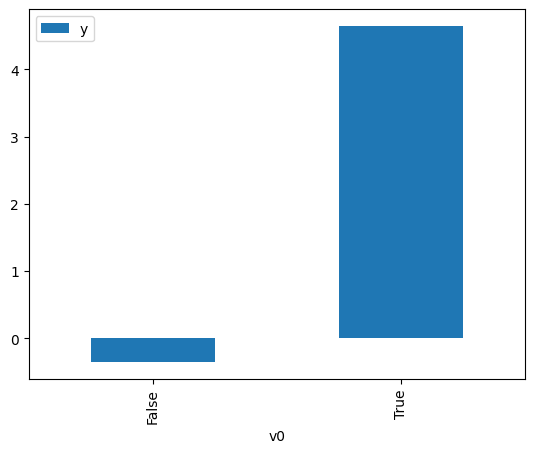

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

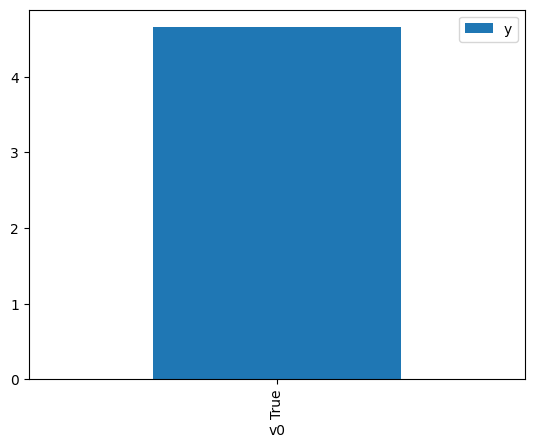

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.494714,False,1.355634,0.387110,2.583244
1,-0.765517,False,-1.274911,0.616625,1.621732
2,0.603402,False,-1.436375,0.368167,2.716161
3,-1.295829,False,-2.238021,0.704450,1.419546
4,-1.479032,False,-1.493501,0.731935,1.366241
...,...,...,...,...,...
995,-0.815855,False,-1.275508,0.625412,1.598947
996,-0.968026,False,-1.810018,0.651456,1.535022
997,-1.023059,False,-1.813410,0.660667,1.513623
998,0.236901,False,0.168007,0.433336,2.307680


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.326729,True,3.431142,0.290800,3.438785
1,-1.021954,True,4.701100,0.339517,2.945358
2,0.602324,True,6.343483,0.631647,1.583162
3,-2.034653,True,4.136265,0.195200,5.122962
4,0.810188,True,4.889690,0.666737,1.499841
...,...,...,...,...,...
995,1.268453,True,7.284094,0.737567,1.355809
996,-1.673314,True,2.606717,0.240751,4.153662
997,0.019167,True,4.614147,0.526665,1.898741
998,-0.720381,True,6.040132,0.391320,2.555454


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              5904.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        16:56:17   Log-Likelihood:                         -1455.0
No. Observations:                1000   AIC:                                      2914.
Df Residuals:                     998   BIC:                                      2924.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0779      0.031     34.285      0.000       1.016       1.140
x2             5.0472      0.049    103.940      0.000       4.952       5.142
==============================================================================
Omnibus:                        1.244   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                1.127
Skew:                           0.032   Prob(JB):                        0.569
Kurtosis:                       3.152   Cond. No.                         1.55
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""